<a href="https://colab.research.google.com/github/Savvy-Slowley/Big-Data-Cloud/blob/main/Distributed_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import os
import json

# Load Cassava Dataset

In [2]:
dataset, info = tfds.load('cassava', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteI0KMSH/cassava-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteI0KMSH/cassava-test.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteI0KMSH/cassava-validation.tfrecord*...:   0%|     …

Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


May or may not use

In [3]:
# Extend the cassava dataset classes with 'unknown'
class_names = info.features['label'].names + ['unknown']

# Map the class names to human readable names
name_map = dict(
    cmd='Mosaic Disease',
    cbb='Bacterial Blight',
    cgm='Green Mite',
    cbsd='Brown Streak Disease',
    healthy='Healthy',
    unknown='Unknown')

print(len(class_names), 'classes:')
print(class_names)
print([name_map[name] for name in class_names])

6 classes:
['cbb', 'cbsd', 'cgm', 'cmd', 'healthy', 'unknown']
['Bacterial Blight', 'Brown Streak Disease', 'Green Mite', 'Mosaic Disease', 'Healthy', 'Unknown']


In [4]:
Num_classes = info.features['label'].num_classes
Num_classes

5

# Preprocess Data 

In [5]:
def preprocess_data(image,label):
  image = tf.image.resize(image, (300, 300))
  return tf.cast(image, tf.float32) / 255. , label

# Keras ResNet Model with Functional API

In [19]:
def create_model():
  base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1016, activation='relu')(x)
  predictions = tf.keras.layers.Dense(Num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
  return model

## Strategy

### Mirror

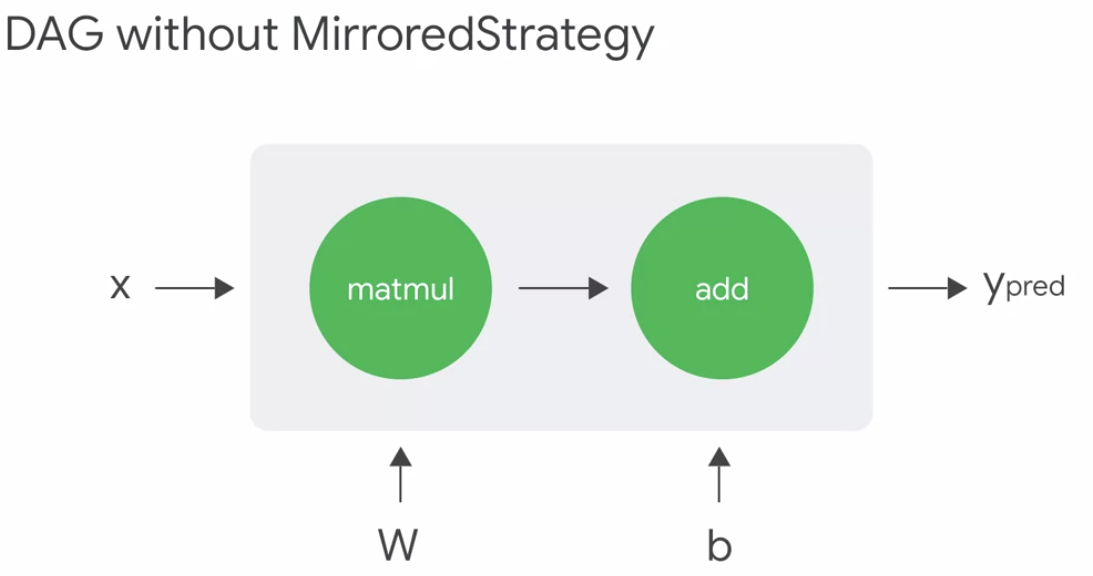

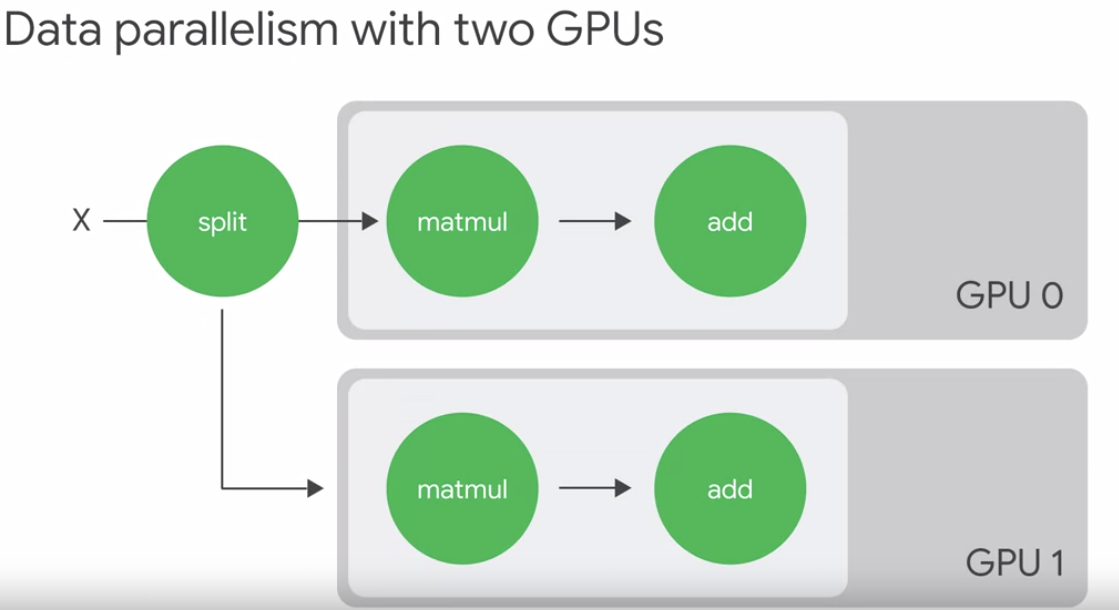

In [12]:
# Create Strategy object
strategy = tf.distribute.MirroredStrategy()

In [27]:
# If I have 2 GPUs then they will each process 32 examples per step
# 64 is the global batch size and is the per replica batch size
batch_size = 64 * strategy.num_replicas_in_sync

### Multimirror

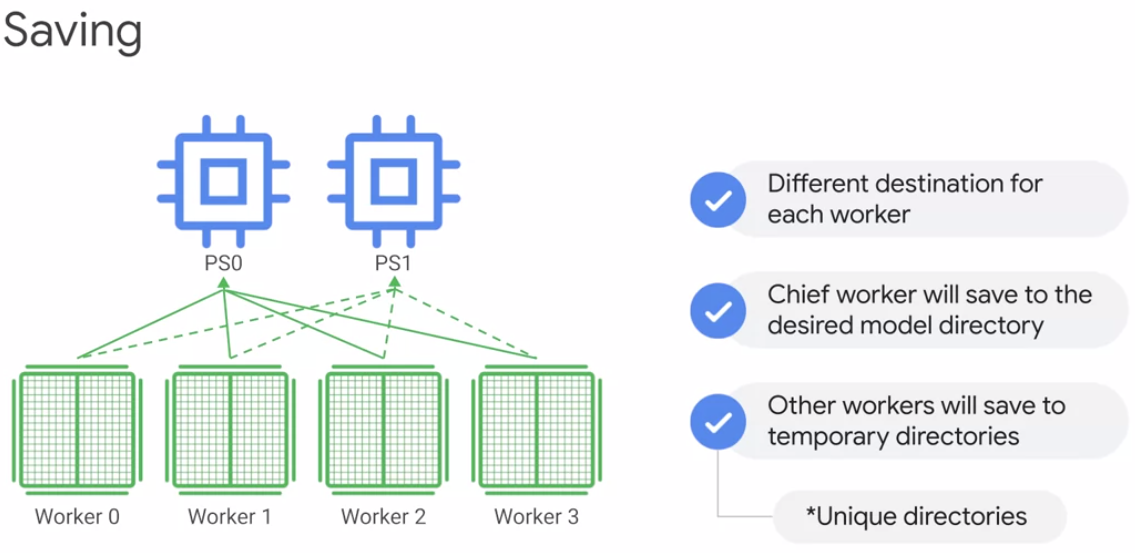

In [ ]:
# Tf_CONFIG - Which machines are part of cluster
# Cluster - Dictionary that contains all IPs and ports of all devices
# Chief - Worker takes on extra work 
# Worker - Replicated computation is executed 
os.environ["Tf_CONFIG"] = json.dumps({
    "cluster": {
        "chief": ["host1:port"]
        "worker": ["host2:port","host3:port"],        
    }
    "task" :{"type": "worker", "index": 1}
})

In [ ]:
# Create Strategy object
strategy = tf.distribute.MultiWorkerMirroredStrategy()

## TPU

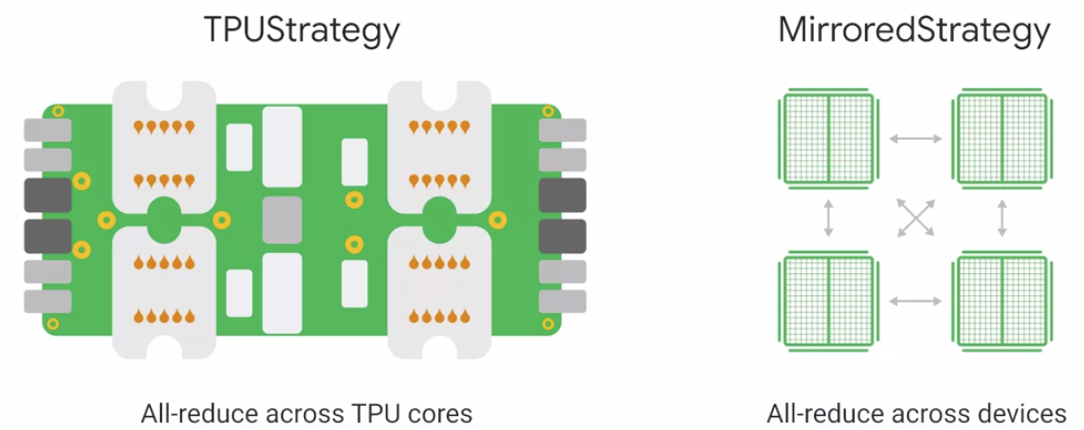

In [ ]:
# Create Strategy object
strategy = tf.distribute.TPUStrategy()

## Parameter

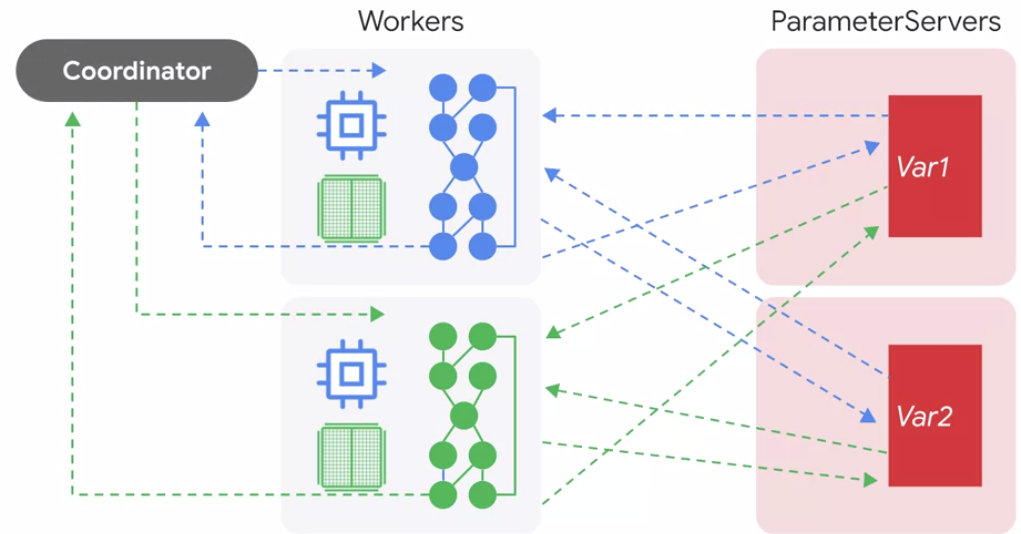

In [ ]:
# Create Strategy object
strategy = tf.distribute.ParameterServerStrategy(tf.distribute.cluster_resolver.TFConfigClusterResolver())

In [ ]:
def dataset_fn(input_context):
  ...
  return dataset

dc = tf.keras.utils.experimental.DatasetCreator(dataset_fn)

# Same for All Strategies

In [20]:
# Create model variable with strategy scope which basically wrap the creation of the model parameters within scope strategies
with strategy.scope():
  model = create_model()
  model.compile(
      loss= 'sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(.0001),
      metrics=['accuracy']
  )

In [29]:
# Map, shuffle & Prefetch

train_data = dataset['train'].map(lambda x: preprocess_data(x['image'], x['label']))
train_data = train_data.shuffle(1000)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# model.fit(train_data, epochs=5)